Entregable: Simple Image Operations

Integrantes:

*   Blabla
*   Blabla



# 1. Simple Image Operations

## Table of Contents
1. [Librerias](#librerias)
2. [Obtención de imágenes](#images)
3. [Resizing Images](#resize)
4. [Negative Images](#negative)
5. [Logarithmic Transformation](#log)
6. [Image Binarizer](#bin)
7. [Image Quantizer](#quant)

## 1.Importing Libraries <a class="anchor" id="librerias" ></a>

In [1]:
from matplotlib import image as mpimg
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests
import cv2

## 2. Obtención de imágenes <a class="anchor" id="images" ></a>


Primero, crearemos un helper para poder hacer uso de imágenes encontradas en internet, así evitamos la necesidad de descargarlas.

In [2]:
def imread_url_bgr(url: str, timeout: int = 10, session: requests.Session | None = None) -> np.ndarray:
    ''' Fetch bytes and decode with OpenCV '''
    sess = session or requests.Session()
    headers = {"User-Agent": "Mozilla/5.0"}
    r = sess.get(url, headers=headers, timeout=timeout)
    r.raise_for_status()
    arr = np.frombuffer(r.content, dtype=np.uint8)
    img = cv2.imdecode(arr, cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f"OpenCV no pudo decodificar la imagen: {url}")
    return img

A continuación, seleccionaremos las imágenes a utilizar, las cuales buscan servir de ejemplo para un caso particular que añade complejidad a la visión computacional, el contraste.

In [3]:
img_high_contrast_cat = "https://i.pinimg.com/originals/86/43/51/864351816db116f5a051ec03fa9ac389.jpg"
img_low_contrast_cat = "https://i.pinimg.com/originals/7e/7e/68/7e7e68cf41d2006a259993d0b201e1aa.jpg"

Las imágenes describen un felino en la nieve, el objetivo es estudiar si el bajo contraste posee un papel importante al momento de determinar las operaciones matriciales a utilizar sobre las imágenes.

In [4]:
with requests.Session() as s:
    img_high_contrast_bgr = imread_url_bgr(img_high_contrast_cat, session=s)
    img_low_contrast_bgr = imread_url_bgr(img_low_contrast_cat,  session=s)

Se procede a visualizar las imágenes:

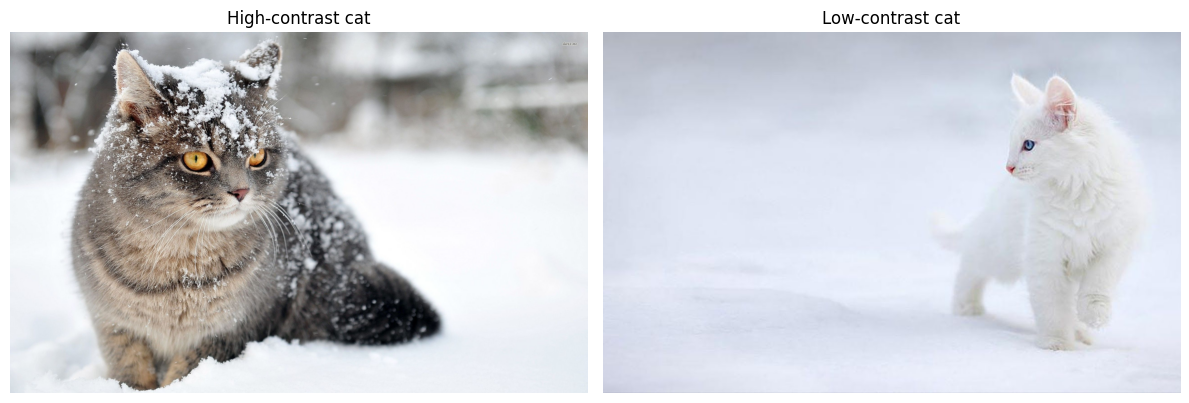

In [5]:
# Nos aseguramos de utilizar las imágenes con los canales de colores correctos.
# BGR -> RGB
img_high_contrast_rgb = cv2.cvtColor(img_high_contrast_bgr, cv2.COLOR_BGR2RGB)
img_low_contrast_rgb  = cv2.cvtColor(img_low_contrast_bgr,  cv2.COLOR_BGR2RGB)

# Visualizamos en grilla
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img_high_contrast_rgb)
axes[0].set_title("High-contrast cat")
axes[0].axis("off")

axes[1].imshow(img_low_contrast_rgb)
axes[1].set_title("Low-contrast cat")
axes[1].axis("off")

plt.tight_layout()
plt.show()

## Ajuste de tamaño <a class="anchor" id="resize"></a>

Al momento de trabajar en visión computacional, lo normal es que el dataset tenga dimensiones consistentes. Existen diferentes maneras de sobrellevar esto, ya sea recortando, añadiendo padding, entre otros. Primero, validaremos si es necesario reajustar sus dimensiones.

In [ ]:
print("Dimensiones de imagen con alto contraste:")
print(img_high_contrast_rgb.shape)
print("Dimensiones de imagen con bajo contraste:")
print(img_low_contrast_rgb.shape)

Dimensiones de imagen con alto contraste:
(1600, 2560, 3)
Dimensiones de imagen con bajo contraste:
(727, 1163, 3)


Claramente las imágenes no tienen las mismas dimensiones, es por ello, que se procede a ajustar sus dimensiones. Como regla general, es necesario evitar imágenes muy grandes, puesto que aumento el tiempo de procesamiento al tener que leer una mayor cantidad de pixeles. Por esto mismo, ajustaremos a un tamaño más pequeño.

In [ ]:
from PIL import Image, ImageOps
import numpy as np

def pad_to_200(img_rgb, fill=(0,0,0)):
    im = Image.fromarray(img_rgb)
    out = ImageOps.pad(im, (360, 360), method=Image.LANCZOS, color=fill, centering=(0.5, 0.5))
    return np.array(out)

img_high_contrast_rgb_scaled = pad_to_200(img_high_contrast_rgb)
img_low_contrast_rgb_scaled  = pad_to_200(img_low_contrast_rgb)

En este caso, usaremos un tamaño de 360 pixeles de ancho. Nos preocuparemos en primer lugar por mantener el *aspect ratio*, puesto que el reajuste de tamaño, puede afectar en la distorsión de las formas en la imagen. Haremos uso de Padding para mitigar la pérdida del aspect ratio y poder mantener imágenes cuadradas.

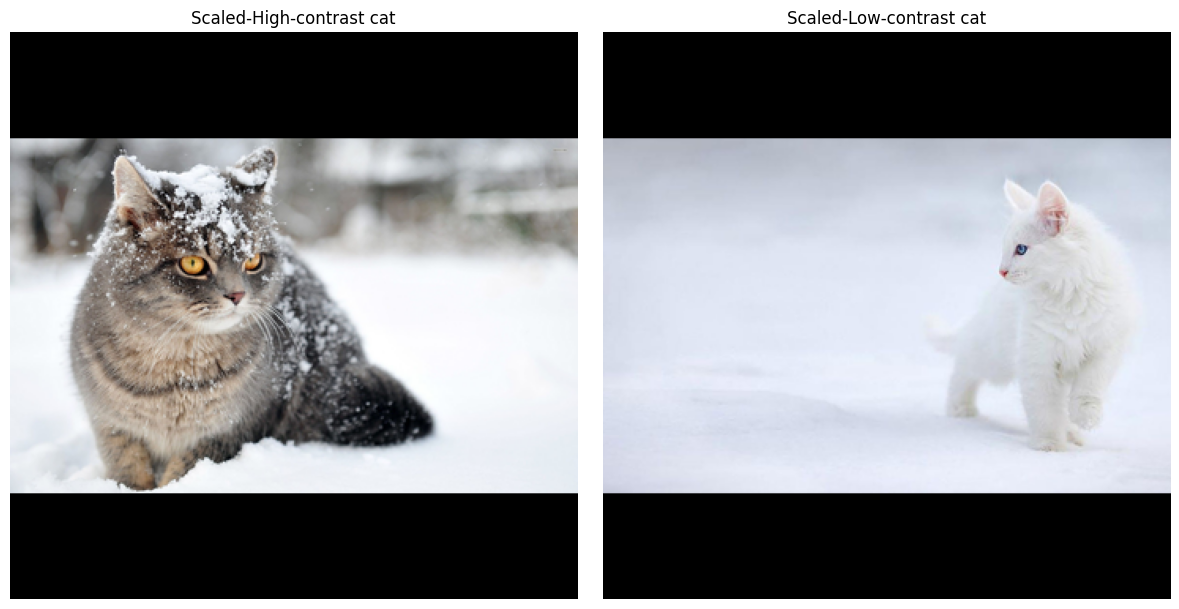

In [ ]:
# Visualizamos en grilla
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img_high_contrast_rgb_scaled)
axes[0].set_title("Scaled-High-contrast cat")
axes[0].axis("off")

axes[1].imshow(img_low_contrast_rgb_scaled)
axes[1].set_title("Scaled-Low-contrast cat")
axes[1].axis("off")

plt.tight_layout()
plt.show()

## Negative Images <a class="anchor" id="negative"></a>

Para una primera transformación, haremos uso de la *transformación negativa*, la cual consiste en calcular el negativo (inverso) de cada imagen: para imágenes uint8 en rango [0,255], cada píxel 𝑣 pasa a (255−𝑣), permitiendo que los colores se transformen hacia su “complementario” en RGB.

In [ ]:
neg_img_high_contrast_rgb_scaled = 255 - img_high_contrast_rgb_scaled
neg_img_low_contrast_rgb_scaled = 255 - img_low_contrast_rgb_scaled


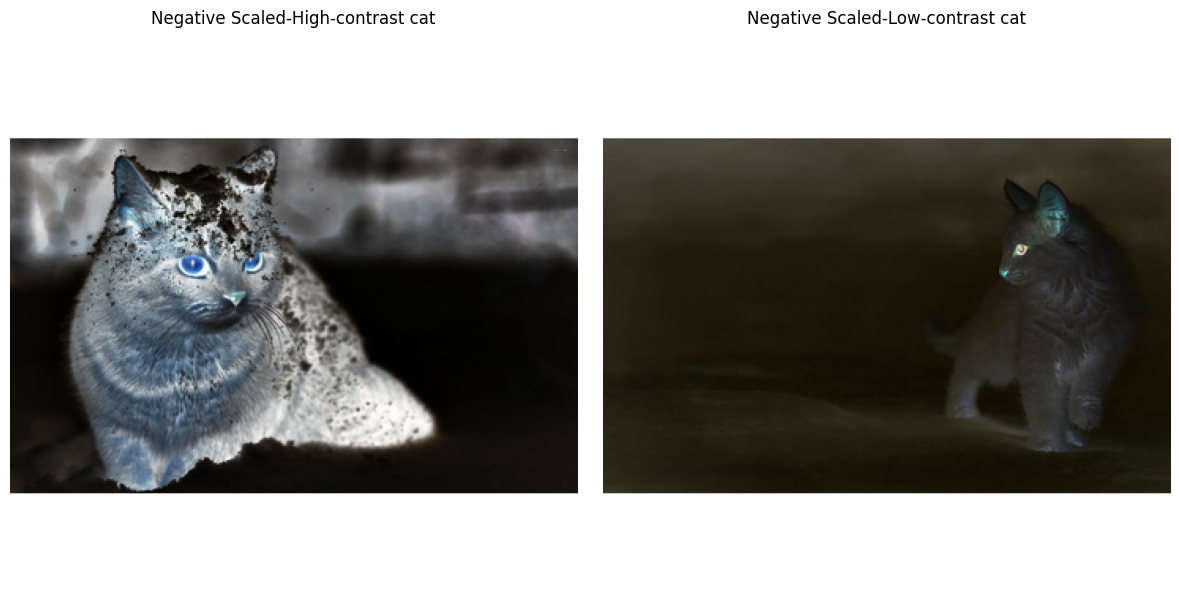

In [ ]:
# Visualizamos en grilla
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(neg_img_high_contrast_rgb_scaled)
axes[0].set_title("Negative Scaled-High-contrast cat")
axes[0].axis("off")

axes[1].imshow(neg_img_low_contrast_rgb_scaled)
axes[1].set_title("Negative Scaled-Low-contrast cat")
axes[1].axis("off")

plt.tight_layout()
plt.show()

Se aprecia de forma inmediata que aquellos colores claros como la nieve, pasa a una tonalidad oscura. Este tipo de transformación es útil cuando hay detalles débiles sobre fondos muy brillantes (rasgos en nieve o niebla, texto desvaído, radiografías/microscopía), porque al invertir la escala el fondo se vuelve oscuro y aumenta la legibilidad/segmentación con umbrales o filtros pensados para detección de objetos “oscuro sobre claro”, por ende, es más útil para imágenes de alto contraste como el caso de la imagen izquierda. Un ejemplo de caso de uso puede ser la *normalización de datasets heterogéneos*, pues si algunas imágenes tienen el objeto oscuro y otras claro, invierte solo las “oscuras” para unificar el supuesto “objeto claro” y reusar el mismo pipeline,como en el caso de señaléticas o letreros con texto blanco sobre negro, en donde se puede invertir los colores para reutilizar un pipeline de detección de texto ya entrenado para letras negras sobre fondo blanco.

## Transformación logarítmica <a class="anchor" id="log"></a>

$$
S = c * log (1 + r)
$$

where,
- $R$ = input pixel value
- $C$ = scaling constant and
- $S$ = output pixel value

The value of $c$ is chosen such that we get the maximum output value corresponding to the bit size used. So, the formula for calculating $c$  is as follows:

$c = 255 / (log (1 + $ max input pixel value $))$

In [ ]:

# Apply log transformation method
c = 255.0 / np.log1p(255.0)

# Use same c for both images
log_img_high_contrast_rgb_scaled = (np.log1p(img_high_contrast_rgb_scaled.astype(np.float32)) * c).clip(0,255).astype(np.uint8)
log_img_low_contrast_rgb_scaled  = (np.log1p(img_low_contrast_rgb_scaled.astype(np.float32))  * c).clip(0,255).astype(np.uint8)


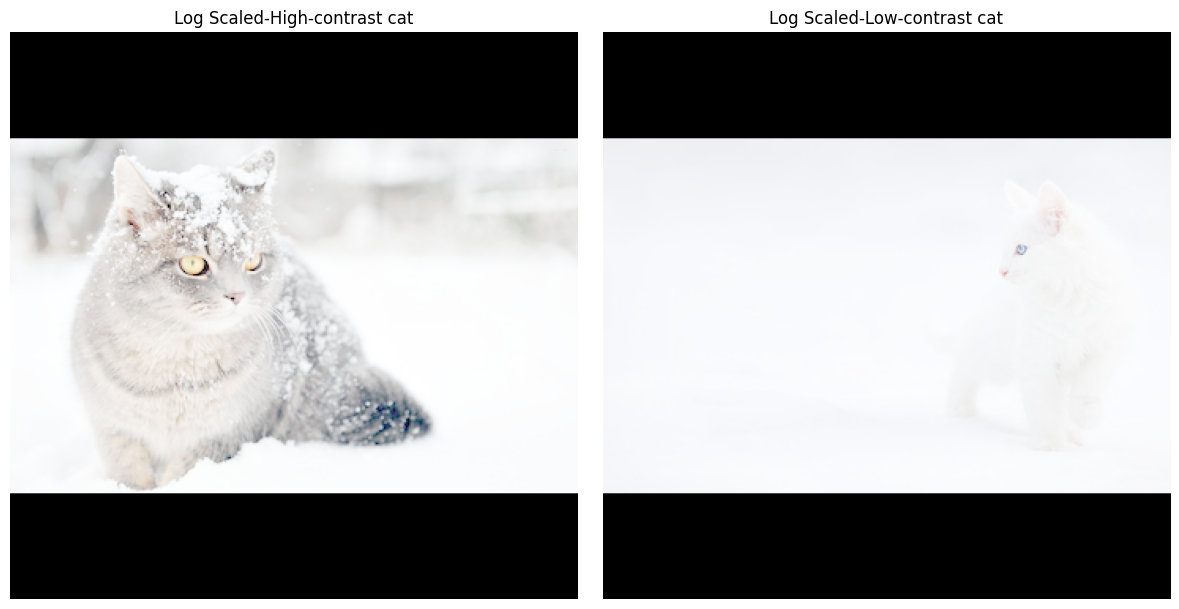

In [ ]:
# Visualizamos en grilla
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(log_img_high_contrast_rgb_scaled)
axes[0].set_title("Log Scaled-High-contrast cat")
axes[0].axis("off")

axes[1].imshow(log_img_low_contrast_rgb_scaled)
axes[1].set_title("Log Scaled-Low-contrast cat")
axes[1].axis("off")

plt.tight_layout()
plt.show()

Notemos que la transformación $S = c * log (1 + r)$ es monótona y cóncava con dereivada decreciente definido como:

$$f'(r) = \frac{c}{1+r}$$

Esto implica que expande las diferencias en sombra debido a que valores bajos de r implican valores altos de f'(r) y comprime diferencias de valores altos al hacer la derivada más pequeña, volviendo más plano los colores de una imagen con bajo contraste, como es el caso de la segunda imagen con gato blanco en fondo blanco. Esto hace que se pierda información respecto a la diferencia entre el fondo y el gato.

## Image Binarizer (Thresholding) <a class="anchor" id="bin"></a>

El siguiente objetivo es poder separar en base a brillo de la imagen, para ello, haremos uso de la imagen en escala de grises.

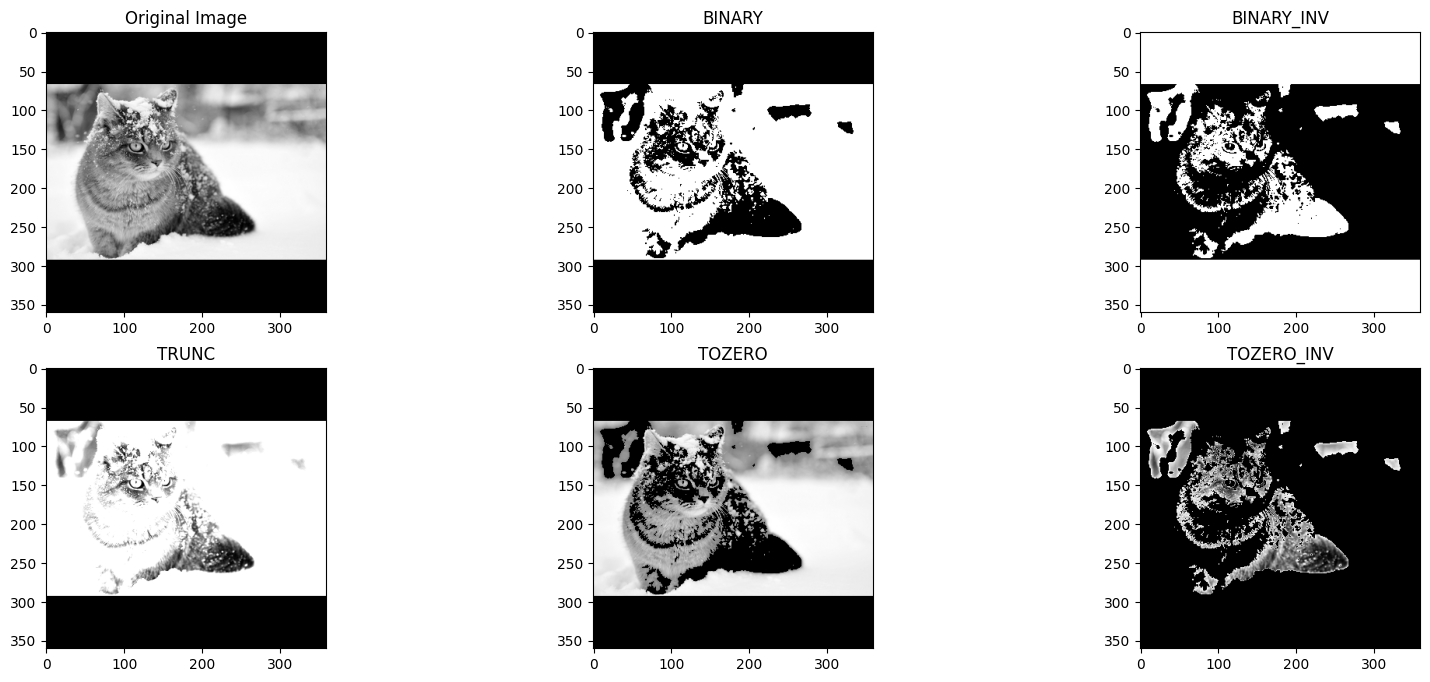

In [ ]:
# Primero, lo pasamos a escala de grises en un canal único
gray_img_high_contrast_rgb_scaled = cv2.cvtColor(img_high_contrast_rgb_scaled, cv2.COLOR_RGB2GRAY)

ret,thresh1 = cv2.threshold(gray_img_high_contrast_rgb_scaled,127,255,cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(gray_img_high_contrast_rgb_scaled,127,255,cv2.THRESH_BINARY_INV)
ret,thresh3 = cv2.threshold(gray_img_high_contrast_rgb_scaled,127,255,cv2.THRESH_TRUNC)
ret,thresh4 = cv2.threshold(gray_img_high_contrast_rgb_scaled,127,255,cv2.THRESH_TOZERO)
ret,thresh5 = cv2.threshold(gray_img_high_contrast_rgb_scaled,127,255,cv2.THRESH_TOZERO_INV)

titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [gray_img_high_contrast_rgb_scaled, thresh1, thresh2, thresh3, thresh4, thresh5]
n = np.arange(6)

fig = plt.figure(figsize=(20, 8))
for i in n:
  plt.subplot(2,3,i+1), plt.imshow(images[i],'gray')
  plt.title(titles[i])

plt.show()

Se evidencia que:


* THRESH_BINARY
dst = M si I > T; en otro caso 0
→ Imagen blanco/negro: todo lo más claro que 127 pasa a 255; lo demás negro. Útil para segmentar objetos claros.

* THRESH_BINARY_INV
dst = 0 si I > T; en otro caso M
→ Igual que arriba pero invertido. Útil para objetos oscuros sobre fondo claro, que es el caso de la imagen del gato en cuestión.

* THRESH_TRUNC
dst = T si I > T; en otro caso I
→ Recorta altas luces: aplana todo lo que está por encima de 127 al valor 127, preservando sombras.

* THRESH_TOZERO
dst = I si I > T; en otro caso 0
→ Suprime fondo oscuro: conserva solo las regiones más brillantes, deja 0 lo demás. Útil si se quiere generar máscaras sobre sombras.

* THRESH_TOZERO_INV
dst = 0 si I > T; en otro caso I
→ Suprime altas luces: conserva solo regiones oscuras, pone 0 lo brillante, en este caso, desaparece todo el fondo prácticamente pero sin perder la tonalidad general del gato.



## Image Quantizer  <a class="anchor" id="quant"></a>

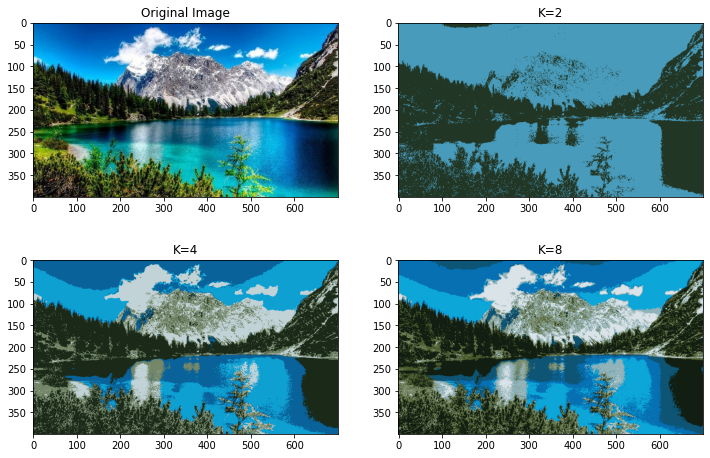

In [ ]:
orig_img = cv2.imread('data/image.jpg')

Z = orig_img.reshape((-1,3))

# convert to np.float32
Z = np.float32(Z)

# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
def colorQuant(Z, K, criteria):

   ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

   # Now convert back into uint8, and make original image
   center = np.uint8(center)
   res = center[label.flatten()]
   res2 = res.reshape((orig_img.shape))
   return res2
res1 = colorQuant(Z, 2, criteria)
res2 = colorQuant(Z, 5, criteria)
res3 = colorQuant(Z, 8, criteria)

fig = plt.figure(figsize=(12, 8))

plt.subplot(221),plt.imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(222),plt.imshow(cv2.cvtColor(res1, cv2.COLOR_BGR2RGB))
plt.title('K=2')

plt.subplot(223),plt.imshow(cv2.cvtColor(res2, cv2.COLOR_BGR2RGB))
plt.title('K=4')

plt.subplot(224),plt.imshow(cv2.cvtColor(res3, cv2.COLOR_BGR2RGB))
plt.title('K=8')

plt.show()

3 Corrección de gamma

Con el objetivo de demostrar el uso de la corrección de gama en el uso especifico de **control de calidad**. En el caso hipotético que el primer proceso de claficación para el empaquetado de las pastillas es separarlas por color.

In [7]:
def adjust_gamma_CV2(image, gamma=1.0):
	invGamma = 1.0 / gamma
	table = np.array([((i / 255.0) ** invGamma) * 255
		for i in np.arange(0, 256)]).astype("uint8")
	return cv2.LUT(image, table)

In [25]:
def adjust_gamma_np(image,gamma):
  gA = np.array( 255 * (image / 255 ) ** gamma, dtype= 'uint8' )
  return gA

In [37]:
imgLink = 'https://st4.depositphotos.com/18384580/27306/i/450/depositphotos_273066460-stock-photo-set-four-different-color-yellow.jpg'
imgLink = 'https://www.shutterstock.com/image-illustration/pills-different-colors-3d-rendering-260nw-2335144051.jpg'
with requests.session() as s:
    img_bgr = imread_url_bgr(imgLink, session=s)

img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

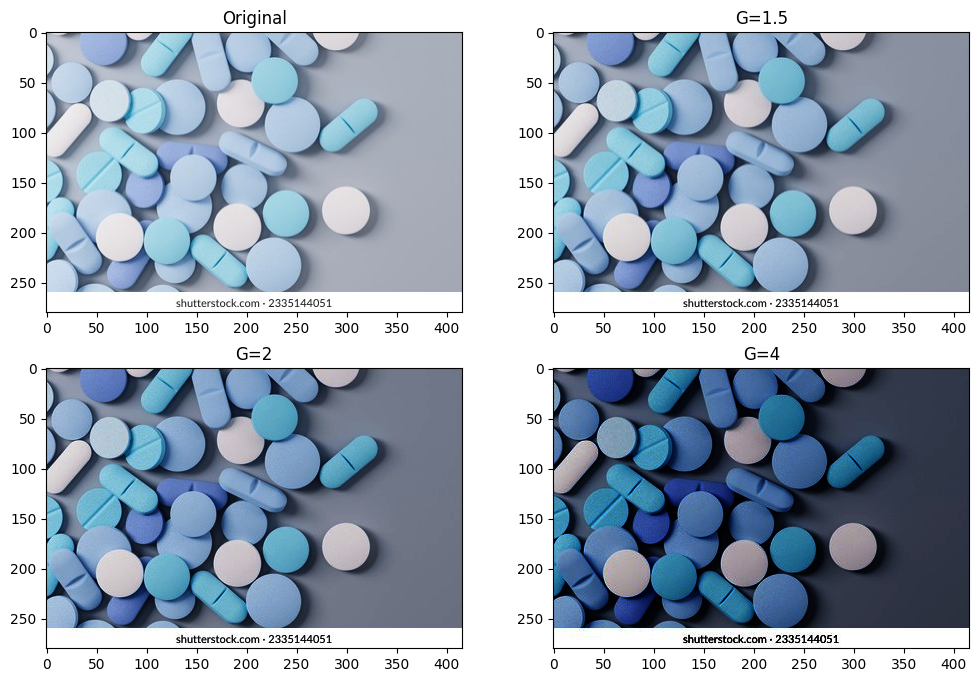

In [43]:
g1 = adjust_gamma_np(img_bgr,1.5)
g2 = adjust_gamma_np(img_bgr,2)
g3 = adjust_gamma_np(img_bgr,4)

fig = plt.figure(figsize=(12, 8))

plt.subplot(221),plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.title('Original')

plt.subplot(222),plt.imshow(cv2.cvtColor(g1, cv2.COLOR_BGR2RGB))
plt.title('G=1.5')

plt.subplot(223),plt.imshow(cv2.cvtColor(g2, cv2.COLOR_BGR2RGB))
plt.title('G=2')

plt.subplot(224),plt.imshow(cv2.cvtColor(g3, cv2.COLOR_BGR2RGB))
plt.title('G=4')

plt.show()

Resultado:
Se obtinen resultados con mayor contraste que un sistema de visión por computadora será capaz de disernir las diferencias entre una otra u otra categoria evitando asi fallos en la clasificación (falsos positivos o negativos).

Referencias:
-https://www.e-consystems.com/blog/camera/technology/what-is-gamma-correction-and-why-is-it-so-crucial-for-embedded-vision-systems/

-https://pyimagesearch.com/2015/10/05/opencv-gamma-correction/

-https://medium.com/@sinhaaa003/transforming-images-rgb-to-grayscale-and-gamma-correction-with-python-fe5a0afa12b9

4 Sustracción de imágenes

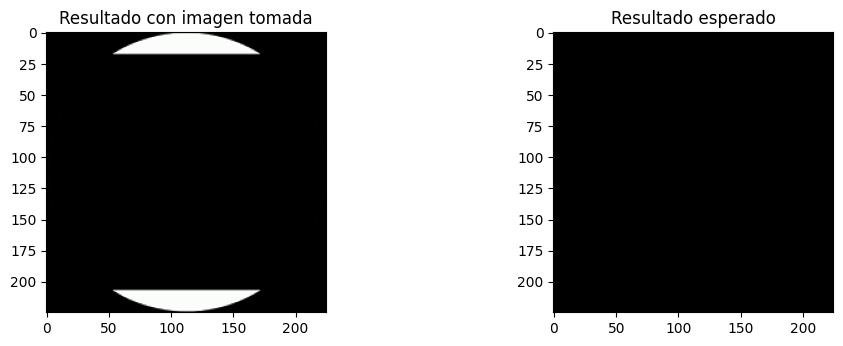

In [49]:
imgTaken = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSOEp4Ylu8i1Dp9hDWW7QuiPleotFEtjnWd_Q&s'
imgExp = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ-PCEuK-efMWe6zyWtfg84dYdxvr1AlbqNEg&s'
with requests.session() as s:
    imgT = imread_url_bgr(imgTaken, session=s)
    imgE = imread_url_bgr(imgExp, session=s)

sustra1 = cv2.subtract(imgE, imgT)
sustra2 = cv2.subtract(imgE, imgE)

fig = plt.figure(figsize=(12, 8))

plt.subplot(221),plt.imshow(cv2.cvtColor(sustra1, cv2.COLOR_BGR2RGB))
plt.title('Resultado con imagen tomada')

plt.subplot(222),plt.imshow(cv2.cvtColor(sustra2, cv2.COLOR_BGR2RGB))
plt.title('Resultado esperado')

plt.show()